In [1]:
import astropy.io.fits
import astropy.io.fits
import numpy as np
import numpy.ma as ma
from astropy.stats import sigma_clip
from scipy.interpolate import interp1d
import causticpy
import matplotlib.pyplot as plt
from numpy import log as ln
import astropy.io.fits
from astropy.table import Table
import matplotlib.pyplot as plt
import scipy as sp
import scipy.integrate as integrate
from scipy import log,exp,sqrt,stats
from astropy import units as u
import astropy.constants as const
from scipy.optimize import curve_fit
from scipy.integrate import quad
from astropy.stats import biweight_location, biweight_scale, bootstrap
from astropy.cosmology import LambdaCDM
from scipy.interpolate import interp1d
from astropy.coordinates import SkyCoord
import scipy.stats as stats
from astLib import astCoords as aco
from astLib import astStats as ast
from astLib import astCalc as aca
from astropy.stats import sigma_clip 
from colossus.halo import profile_nfw
import sherpa.astro.ui as ui
import uncertainties
from scipy.optimize import least_squares
from uncertainties import ufloat
from uncertainties import ufloat, umath, unumpy
try:
    from uncertainties import Variable
except ImportError:
    from uncertainties.core import Variable
cosmos = LambdaCDM(H0=67.77* u.km / u.Mpc / u.s, Om0=0.307115, Ode0=0.692885)  # define cosmology
c=const.c.to("km/s").value
%matplotlib inline
#path_2_data = 'massive_cluster0.fit' # MACS J0717.5+3745  with 202 members 12 best bins
#path_2_data = 'massive_cluster4.fit'
path_2_data = 'massive_cluster8.fit'
#path_2_data = 'kidstable.fit'
#path_2_data = 'massive_cluster2.fit'
print('opening', path_2_data)
my_file=astropy.io.fits.open(path_2_data)
print(my_file[1].data.columns)
data = my_file[1].data

failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find ds9 on your PATH'
opening massive_cluster8.fit
ColDefs(
    name = 'mem_match_id'; format = 'J'
    name = 'id'; format = 'K'
    name = 'z'; format = 'E'
    name = 'ra'; format = 'D'
    name = 'dec'; format = 'D'
    name = 'r'; format = 'E'
    name = 'p'; format = 'E'
    name = 'pfree'; format = 'E'
    name = 'pcol'; format = 'E'
    name = 'theta_i'; format = 'E'
    name = 'theta_r'; format = 'E'
    name = 'refmag'; format = 'E'
    name = 'refmag_err'; format = 'E'
    name = 'zred'; format = 'E'
    name = 'zred_e'; format = 'E'
    name = 'zred_chisq'; format = 'E'
    name = 'chisq'; format = 'E'
    name = 'ebv'; format = 'E'
    name = 'zspec'; format = 'E'
    name = 'dcent_opt'; format = 'D'
    name = 'dcent'; format = 'D'
    name = 'vel'; format = 'D'
    name = 'cg'; format = 'L'
    name = 'z_lambda'; format = 'D'
    name = 'z_lambda_e'; format = 'D'
    name = 'lambda

In [2]:
lambda_z= data.field('z_lambda')
lambda_z_err= data.field('z_lambda_e')
z_red= data.field('zred')
z_spec= data.field('zspec')

In [3]:
mask=np.where(z_spec>0)
z_sp= z_spec[mask]
len(z_sp)

224

In [4]:
#  magnitudes and redshifts 
mag_g = data.field('mag_g')[mask] # Magnitude in the g band
mag_g_errors=data.field('mag_err_g')[mask]  #errors 
mag_r = data.field('mag_r')[mask] # Magnitude in the r band
mag_r_errors=data.field('mag_err_r')[mask]   #errors
mag_z = data.field('mag_z')[mask]  # Magnitude in the z band
mag_z_errors=data.field('mag_err_z')[mask]    #errors

* Data Preparation: The input data consists of magnitudes (mag_g, mag_r, mag_z) and magnitude errors (mag_g_errors, mag_r_errors, mag_z_errors). The target variable is the spectroscopic redshift (z_sp).

* Data Splitting: The data is split into training and testing sets using the train_test_split function. This allows us to train the model on a portion of the data and evaluate its performance on unseen data.

*  Model Training: A Random Forest Regressor model is chosen as the machine learning algorithm (RandomForestRegressor). The model is trained using the training data (X_train and y_train).

*  Model Prediction: The trained model is used to predict the spectroscopic redshifts for the testing data (X_test). The predicted redshifts are stored in the predicted_redshifts array.

*  Performance Evaluation: The Mean Absolute Error (MAE) is calculated by comparing the predicted redshifts with the true redshifts (y_test). The MAE represents the average absolute difference between the predicted and true redshifts.

*  Average and Median Redshift Calculation: The average redshift is calculated by taking the mean of the predicted redshifts. The median redshift is calculated by taking the median of the predicted redshifts.

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

"""
# Approach:  https://arxiv.org/pdf/2011.12312.pdf

Combine the magnitudes into a single feature matrix.
Define the target variable as the spectroscopic redshift (z_spec).
Split the Data:

Split the data into training and testing sets using the train_test_split function from scikit-learn.
Train the Machine Learning Model:

Choose a regression algorithm such as RandomForestRegressor, Support Vector Machines (SVR), or Neural Network (MLPRegressor).
Create an instance of the chosen model and fit it to the training data using the fit method.
The model learns the relationship between the magnitudes and the spectroscopic redshift.
Predict the Spectroscopic Redshift:

Use the trained model to predict the spectroscopic redshift for the testing data using the predict method.
The predicted redshifts are stored in the predicted_redshifts array.
Evaluate the Performance:

Calculate the mean absolute error (MAE) between the predicted redshifts and the true redshifts using the mean_absolute_error function.
The MAE represents the average absolute difference between the predicted and true redshifts.

"""

# Step 1: Prepare the data
# Assume you have the following arrays: spec_z, mag_g, mag_r, mag_z, mag_err_g, mag_err_r, mag_err_z

# Combine the magnitudes and magnitude errors into a single feature matrix
features = np.column_stack((mag_g, mag_r, mag_z, mag_g_errors, mag_r_errors, mag_z_errors))

# Define the target variable as the spectroscopic redshift
target = z_sp

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Step 3: Train the machine learning model
model = RandomForestRegressor(n_estimators=10000, random_state=42)
model.fit(X_train, y_train)

# Step 4: Predict the spectroscopic redshift for the cluster
predicted_redshifts = model.predict(X_test)

# Step 5: Evaluate the performance of the model
mae = mean_absolute_error(y_test, predicted_redshifts)
print("Mean Absolute Error:", mae)


# Calculate the average redshift
average_redshift = np.mean(predicted_redshifts)

# Calculate the median redshift
median_redshift = np.median(predicted_redshifts)

print("Average Redshift:", average_redshift)
print("Median Redshift:", median_redshift)


Mean Absolute Error: 0.017622180713282688
Average Redshift: 0.5455209579409495
Median Redshift: 0.5448601324439049


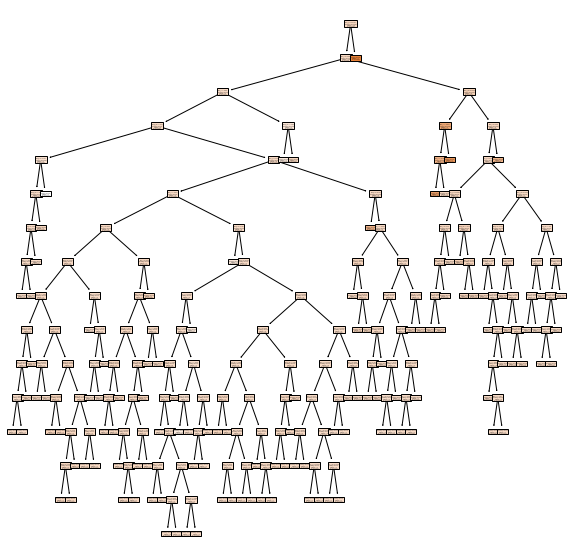

In [7]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
tree = model.estimators_[0]  # Get the first tree in the forest
plt.figure(figsize=(10, 10))
plot_tree(tree, filled=True, feature_names=['mag_g', 'mag_r', 'mag_z', 'mag_g_err', 'mag_r_err', 'mag_z_err'])
plt.show()


In [8]:
from sklearn.tree import export_text

# Get the decision tree from the Random Forest model
tree = model.estimators_[0]  # Get the first tree in the forest

# Generate a textual representation of the decision tree
tree_text = export_text(tree, feature_names=['mag_g', 'mag_r', 'mag_z', 'mag_g_err', 'mag_r_err', 'mag_z_err'])

print(tree_text)


|--- mag_r_err <= 0.12
|   |--- mag_r <= 22.03
|   |   |--- mag_z <= 20.85
|   |   |   |--- mag_g_err <= 0.05
|   |   |   |   |--- mag_g <= 22.11
|   |   |   |   |   |--- mag_g_err <= 0.05
|   |   |   |   |   |   |--- mag_g <= 22.07
|   |   |   |   |   |   |   |--- mag_z <= 18.25
|   |   |   |   |   |   |   |   |--- value: [0.54]
|   |   |   |   |   |   |   |--- mag_z >  18.25
|   |   |   |   |   |   |   |   |--- value: [0.54]
|   |   |   |   |   |   |--- mag_g >  22.07
|   |   |   |   |   |   |   |--- value: [0.54]
|   |   |   |   |   |--- mag_g_err >  0.05
|   |   |   |   |   |   |--- value: [0.55]
|   |   |   |   |--- mag_g >  22.11
|   |   |   |   |   |--- value: [0.42]
|   |   |   |--- mag_g_err >  0.05
|   |   |   |   |--- mag_r_err <= 0.05
|   |   |   |   |   |--- mag_z <= 20.02
|   |   |   |   |   |   |--- mag_r <= 20.92
|   |   |   |   |   |   |   |--- mag_g <= 22.56
|   |   |   |   |   |   |   |   |--- mag_g_err <= 0.05
|   |   |   |   |   |   |   |   |   |--- mag_g <= 22.36


In [13]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.tree import export_graphviz
import graphviz

# Step 1: Prepare the data
# Assume you have the following arrays: spec_z, mag_g, mag_r, mag_z, mag_err_g, mag_err_r, mag_err_z

# Combine the magnitudes and magnitude errors into a single feature matrix
features = np.column_stack((mag_g, mag_r, mag_z, mag_g_errors, mag_r_errors, mag_z_errors))

# Define the target variable as the spectroscopic redshift
target = z_sp

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Step 3: Train the machine learning model
model = RandomForestRegressor(n_estimators=10000, random_state=42)
model.fit(X_train, y_train)

# Step 4: Export the decision tree as DOT file
export_file = 'decision_tree.dot'
export_graphviz(model.estimators_[0], out_file=export_file, feature_names=["mag_g", "mag_r", "mag_z", "mag_g_errors", "mag_r_errors", "mag_z_errors"], class_names=["z_sp"], filled=True)

# Step 5: Render the Graphviz file to a PDF or image
output_file = 'decision_tree.pdf'
graph = graphviz.Source.from_file(export_file)
graph.render(filename=output_file, format='pdf')

# Optionally, display the decision tree in Jupyter Notebook
# graph


'decision_tree.pdf.pdf'

# Using knn method

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error

# Step 1: Prepare the data
# Assume you have the following arrays: spec_z, mag_g, mag_r, mag_z

# Combine the magnitudes into a single feature matrix
features = np.column_stack((mag_g, mag_r, mag_z))

# Define the target variable as the spectroscopic redshift
target = z_sp

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Step 3: Train the K-Nearest Neighbors model and evaluate its performance
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)
knn_predicted_redshifts = knn_model.predict(X_test)
knn_mae = mean_absolute_error(y_test, knn_predicted_redshifts)
print("K-Nearest Neighbors MAE:", knn_mae)


K-Nearest Neighbors MAE: 0.015826654


# using SVR and neural network

In [7]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error

# Step 1: Prepare the data
# Assume you have the following arrays: spec_z, mag_g, mag_r, mag_z

# Combine the magnitudes into a single feature matrix
features = np.column_stack((mag_g, mag_r, mag_z))

# Define the target variable as the spectroscopic redshift
target = z_sp

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Step 3: Train the machine learning models and evaluate their performance


# Support Vector Machines
svm_model = SVR()
svm_model.fit(X_train, y_train)
svm_predicted_redshifts = svm_model.predict(X_test)
svm_mae = mean_absolute_error(y_test, svm_predicted_redshifts)
print("SVM MAE:", svm_mae)

# Neural Network
nn_model = MLPRegressor(hidden_layer_sizes=(100, 50), random_state=42)
nn_model.fit(X_train, y_train)
nn_predicted_redshifts = nn_model.predict(X_test)
nn_mae = mean_absolute_error(y_test, nn_predicted_redshifts)
print("Neural Network MAE:", nn_mae)

print("nn:",np.median(nn_predicted_redshifts) )
print("svm:",np.median(svm_predicted_redshifts) )

SVM MAE: 0.05358002370961567
Neural Network MAE: 0.2352392
nn: 0.29896572
svm: 0.5746972556279335
